In [1]:
import time
import random
import pandas as pd
import utils
import itertools

from typing import List, Tuple, Union
from pytrends.request import TrendReq
from matplotlib import pyplot as plt
from tqdm import tqdm

# Vizu settings
%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 6)

random.seed(1337)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
LANGUAGE = 'en-US'
TIME_ZONE = 360

In [4]:
pytrends = TrendReq(hl=LANGUAGE, tz=TIME_ZONE)

In [5]:
COUNTRIES = utils.load_countries(filename="countries.txt", ignore="ignore.txt")

In [6]:
def get_interest_over_time(kw_list: List[str], tf: str, geo: str, sleep: float = 0.25) -> Union[pd.DataFrame, pd.Series]:
    time.sleep(sleep)
    pytrends.build_payload(kw_list, timeframe=tf, geo=geo)
    return pytrends.interest_over_time().drop(columns=['isPartial'])

def plot_history(results: List[Tuple[str, Union[pd.DataFrame, pd.Series]]], title: str) -> None:
    plt.figure()
    for label, pd_history in results:
        plt.plot(pd_history, label=label)
    plt.ylabel("Interest")
    plt.xlabel("Time")
    plt.legend(loc="upper right")
    plt.title(f"{title.capitalize()}: Interest Over Time")

def get_yearly_interest_by_country(search_terms: List[str],
                                   year: int,
                                   geocode: str,
                                   fetch_interval: int = 1) -> Union[pd.Series, pd.DataFrame]:
    history = []
    first_six_months = f"{year}-1-1 {year}-6-30"
    last_six_months = f"{year}-7-1 {year}-12-31"
    
    for time_period in [first_six_months, last_six_months]:
        history.append(get_interest_over_time(search_terms, time_period, geocode, fetch_interval))
    return pd.concat(history)

def get_daily_trends_by_year(search_terms: List[str], year: int, n_countries: int, fetch_interval: int = 1) -> List[Tuple[str, Union[pd.DataFrame, pd.Series]]]:
    utils.check_is_valid_indexing(n_countries)

    history = []

    for geocode, country in tqdm(get_sampled_countries(n_countries=n_countries), desc="Fetching trends", nrows=n_countries, colour="green"):
        history_frame = get_yearly_interest_by_country(search_terms, year, geocode, fetch_interval) 
        history.append((country, history_frame))
    return history
    
def get_sampled_countries(n_countries: int):
    if n_countries == 0:
        return COUNTRIES
    else:
        return random.sample(COUNTRIES, n_countries)
    

In [9]:
year = 2015
search_term = ["milk"]
n_countries = 2           # 0 = all
fetch_interval = 1       # sleep time between requests

history = get_daily_trends_by_year(search_term, year, n_countries, fetch_interval)

Fetching trends: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


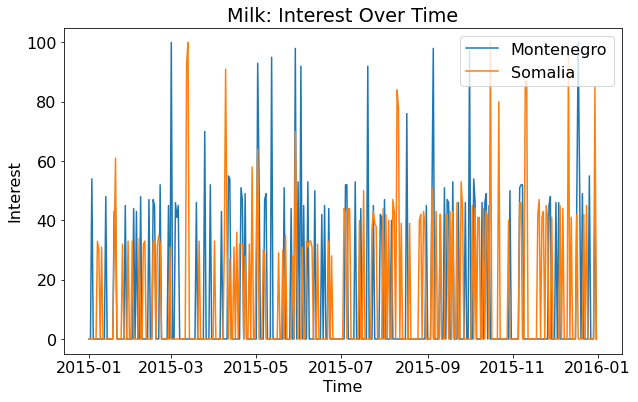

In [10]:
plot_history(history, search_term[0])